In [62]:
import torch
import numpy as np
import h5py 
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 250
from torch.utils.data import DataLoader
import sys 
model_path = "...\\Models architecture"
sys.path.append(model_path)

In [63]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [64]:
galaxy_denoised = '...\\cosmos.h5'
galaxy_w_redshift = '...\\cosmos_25.2_all_with_zphot.h5'

In [65]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, file):
        self.file = file
        self.hdf = h5py.File(file, 'r')

    def __len__(self):
        self.hdf.keys()
        return len(self.hdf["images"])
    
    def __getitem__(self, idx):
        with h5py.File(self.file, 'r') as hf:
            x = hf["images"][idx]
            z = hf["zphot"][idx]
        return x, z

In [66]:
galaxy_w_redshift_dataset = dataset(galaxy_w_redshift)
batchsize = 64
galaxy_loader = DataLoader(galaxy_w_redshift_dataset, batch_size = batchsize, shuffle = False)

In [67]:
data_size = len(galaxy_w_redshift_dataset)
train_size = int(0.9*(data_size))
val_size = data_size - train_size

In [68]:
train_set, val_set = torch.utils.data.random_split(galaxy_w_redshift_dataset, [train_size, val_size])

# Defining the model and loading the weights 

In [69]:
# Importing model
from cvae import VariationalAutoencoder

# Model parameters
nc, nf, z_dim = 2, 64, 32
vae = VariationalAutoencoder(nc, nf, z_dim).to(device)

# Loading trained weights 
weights_path = "...\\test5_z32_beta0.1_weights.pt"
vae.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

# Reconstruction

In [70]:
galaxies, zphot = next(iter(galaxy_loader))

In [71]:
def reconstruct_cvae(galaxies, zphot, cols = 10, colour = 'magma'):
    x_cond = vae.concatenate(galaxies, zphot).to(device)
    pred_galaxies = vae(x_cond)

    figure, axs = plt.subplots(2, cols, figsize = (8, 2))

    for j in range(cols):
        rdm_label = torch.randint(batchsize, size = (1,))
        axs[0,j].imshow(galaxies[rdm_label].squeeze(), cmap = colour)
        axs[0,j].axis("off")
        axs[0,j].annotate(f"{zphot[rdm_label].item():.2f}", xy=(0.6, 0.85), xycoords = 'axes fraction', color = 'white', fontsize = 7)
        axs[1,j].imshow(pred_galaxies[rdm_label].detach().to('cpu').numpy().squeeze(), cmap = 'magma')
        axs[1,j].axis('off')
    plt.subplots_adjust(wspace=0.1 , hspace= -0.3 )

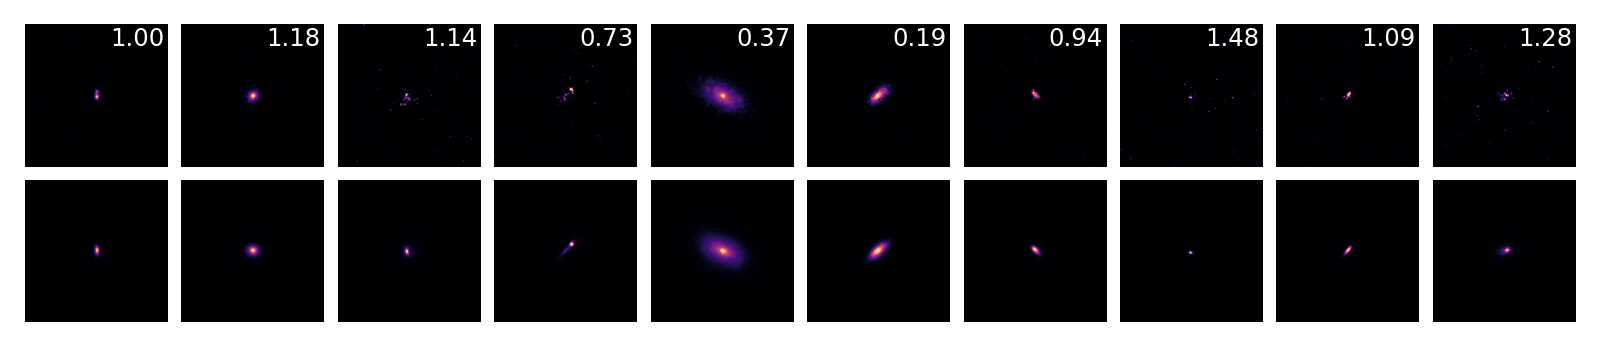

In [76]:
torch.manual_seed(3)
reconstruct_cvae(galaxies, zphot)


# Generation

In [73]:
def generate_cvae(redshift_value, rows = 8, cols = 8, device = 'cuda', colour = 'magma'):
    """
    Generate a 8*8 grid of galaxy images based on the redshift value given in input representing a distribution of the images according to this redshift value.
    A latent space tensor sampled from a uniform multivariate normal distribution is concatenated to the redshift value along the channel dimension
    thanks to the function concatenate defined in the class vae = VariationalAutoencoder(nc, nf, z_dim)
    channel 0 = latent tensor (N, 1, z_dim)
    channel 1 = redshift values (N, 1, z_dim)
    input_concatenated = (N, 2, z_dim)
    Then, the concatenated tensor is fed to the decoder which outputs a prediction of the image input. 
    """
    if type(redshift_value) == torch.Tensor:
        redshift = redshift_value 
    else:
        redshift = torch.tensor([redshift_value]).to(device)
    figure, axs = plt.subplots(rows, cols, figsize = (10,10))
    for i in range(rows):
        for j in range(cols):
            z_generated = torch.normal(0, 1, size = (1,1, z_dim)).to(device)
            generated_galaxies = vae.decoder(vae.concatenate(z_generated, redshift))
            axs[i,j].imshow(generated_galaxies.detach().to('cpu').numpy().squeeze(), cmap = colour)
            axs[i,j].axis('off')
            axs[i,j].annotate(f"{redshift.item():.2f}", xy =(0.1, 0.85) , xycoords = "axes fraction", color = 'white', fontsize = 6 )
    plt.subplots_adjust(wspace = 0.1, hspace = -0.1)

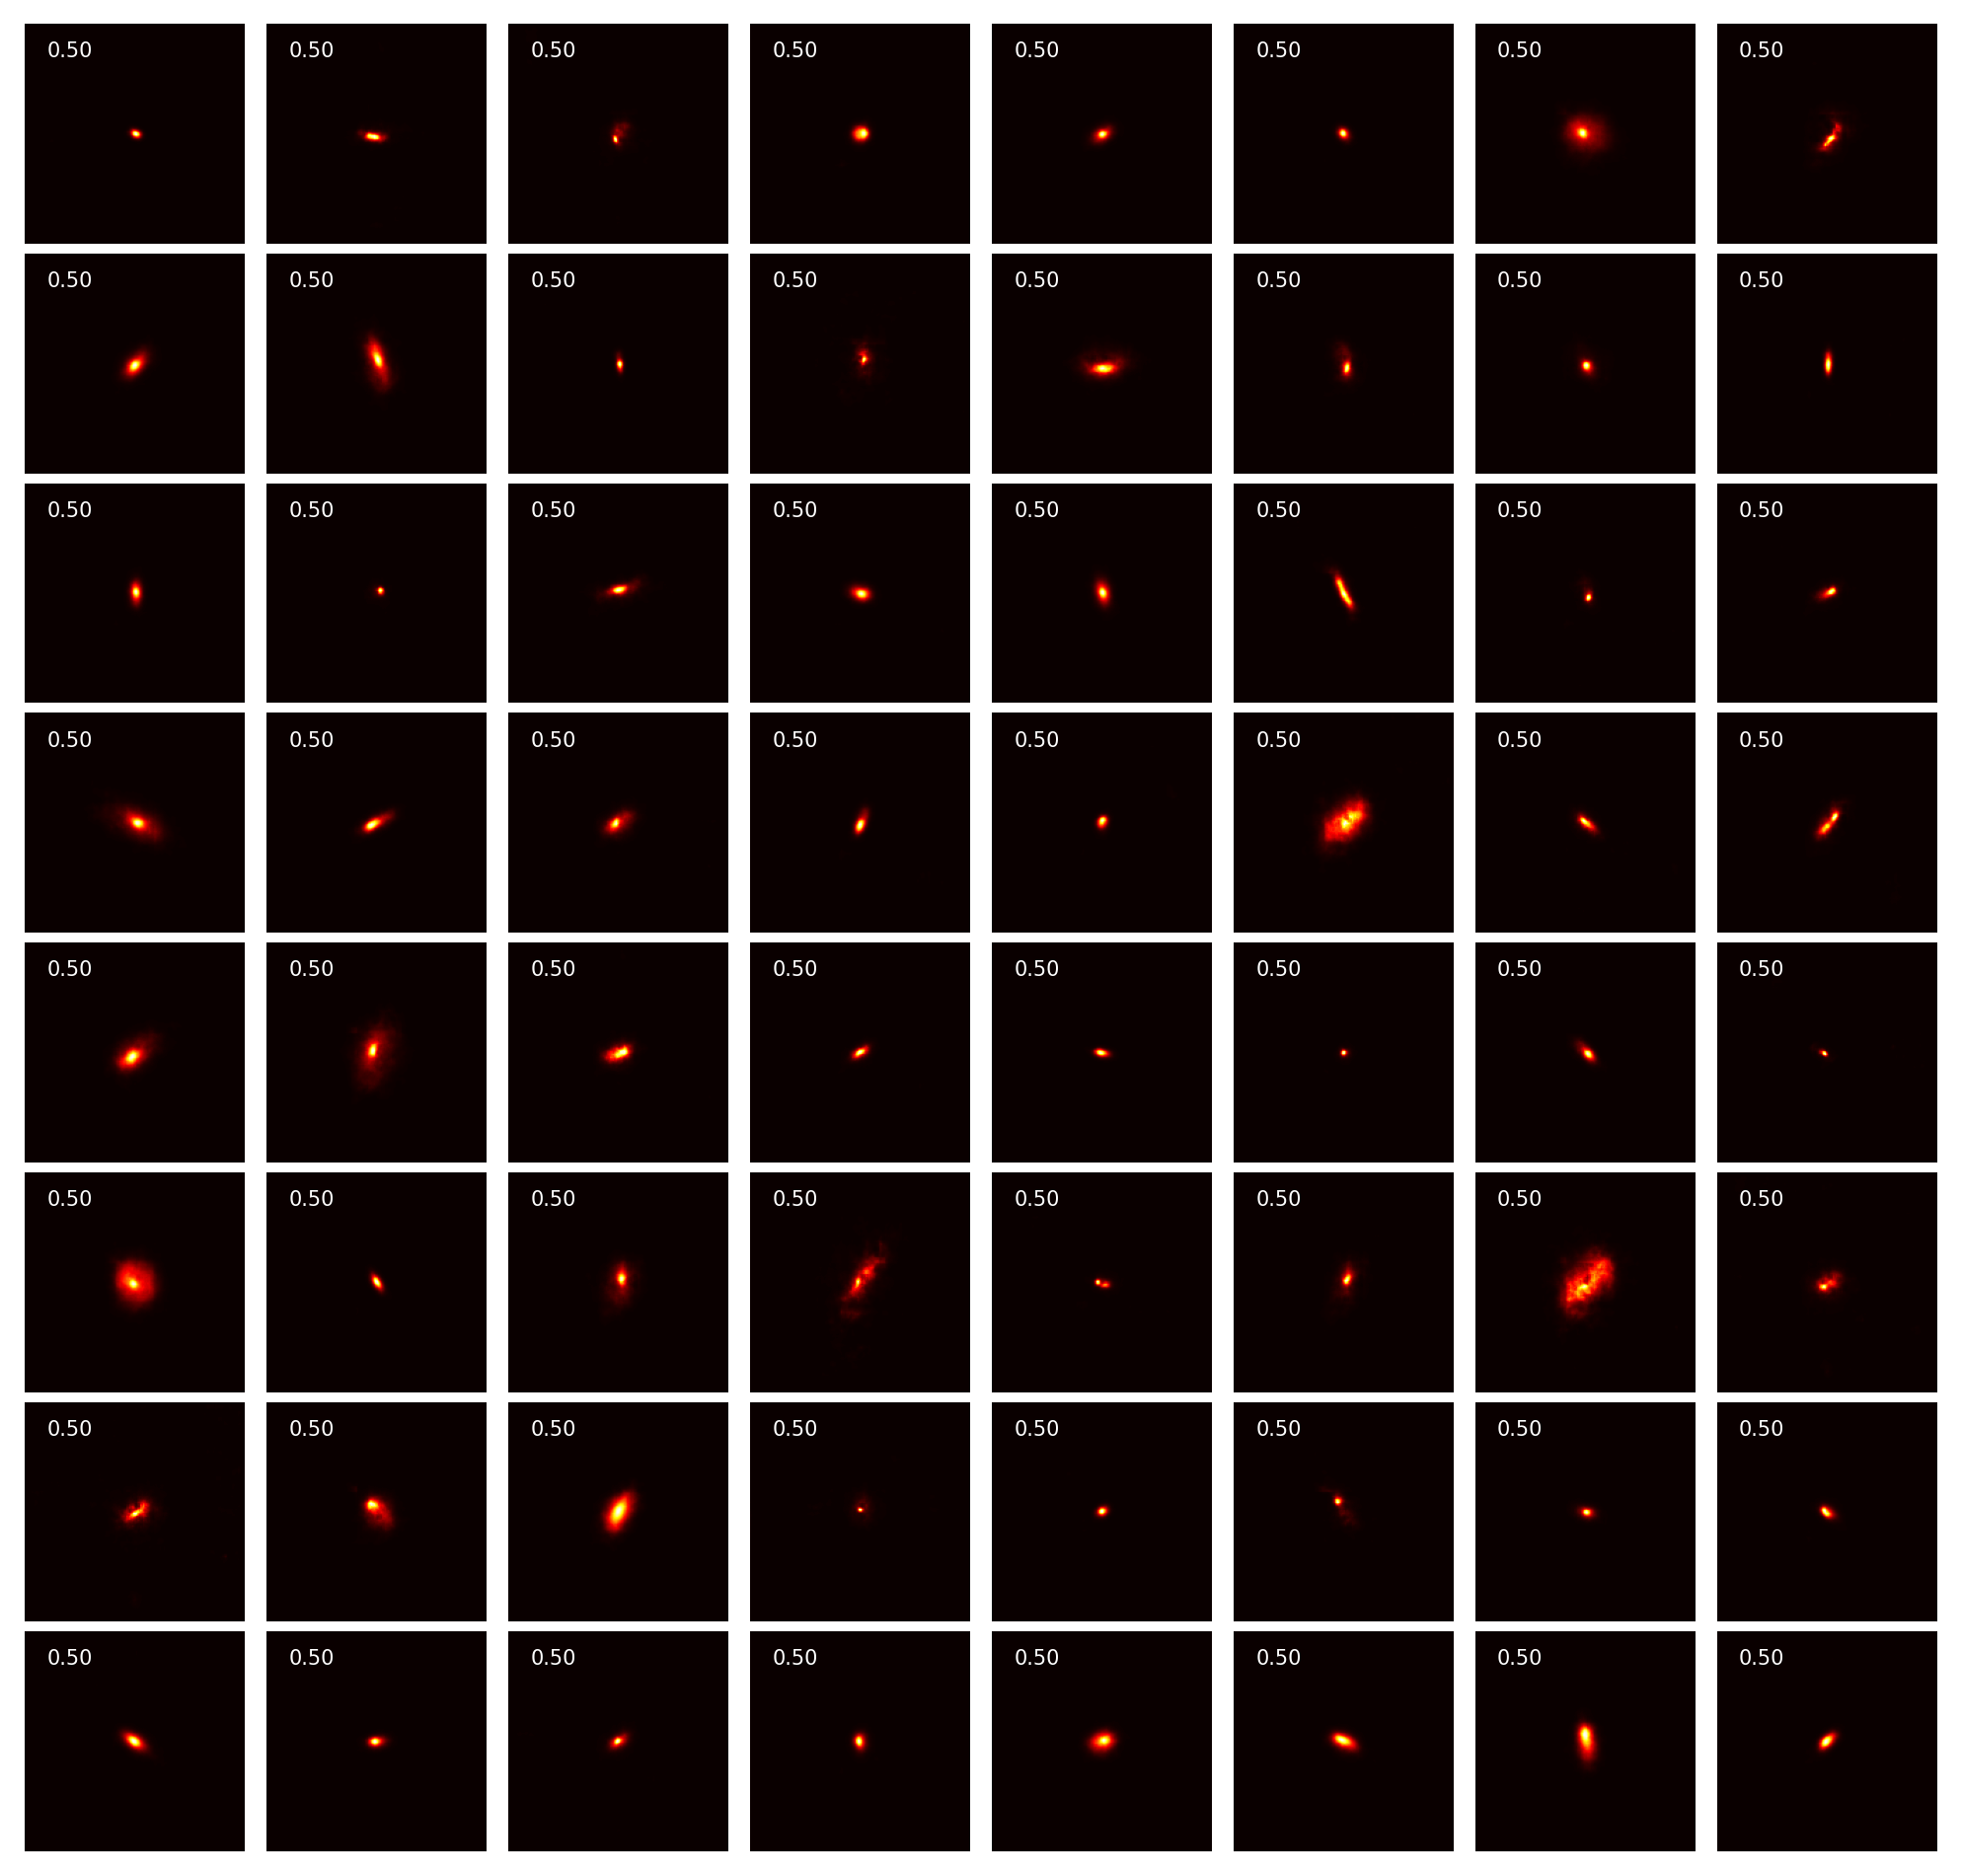

In [78]:
torch.manual_seed(0)
redshift = 0.5
generate_cvae(redshift, colour = 'hot')


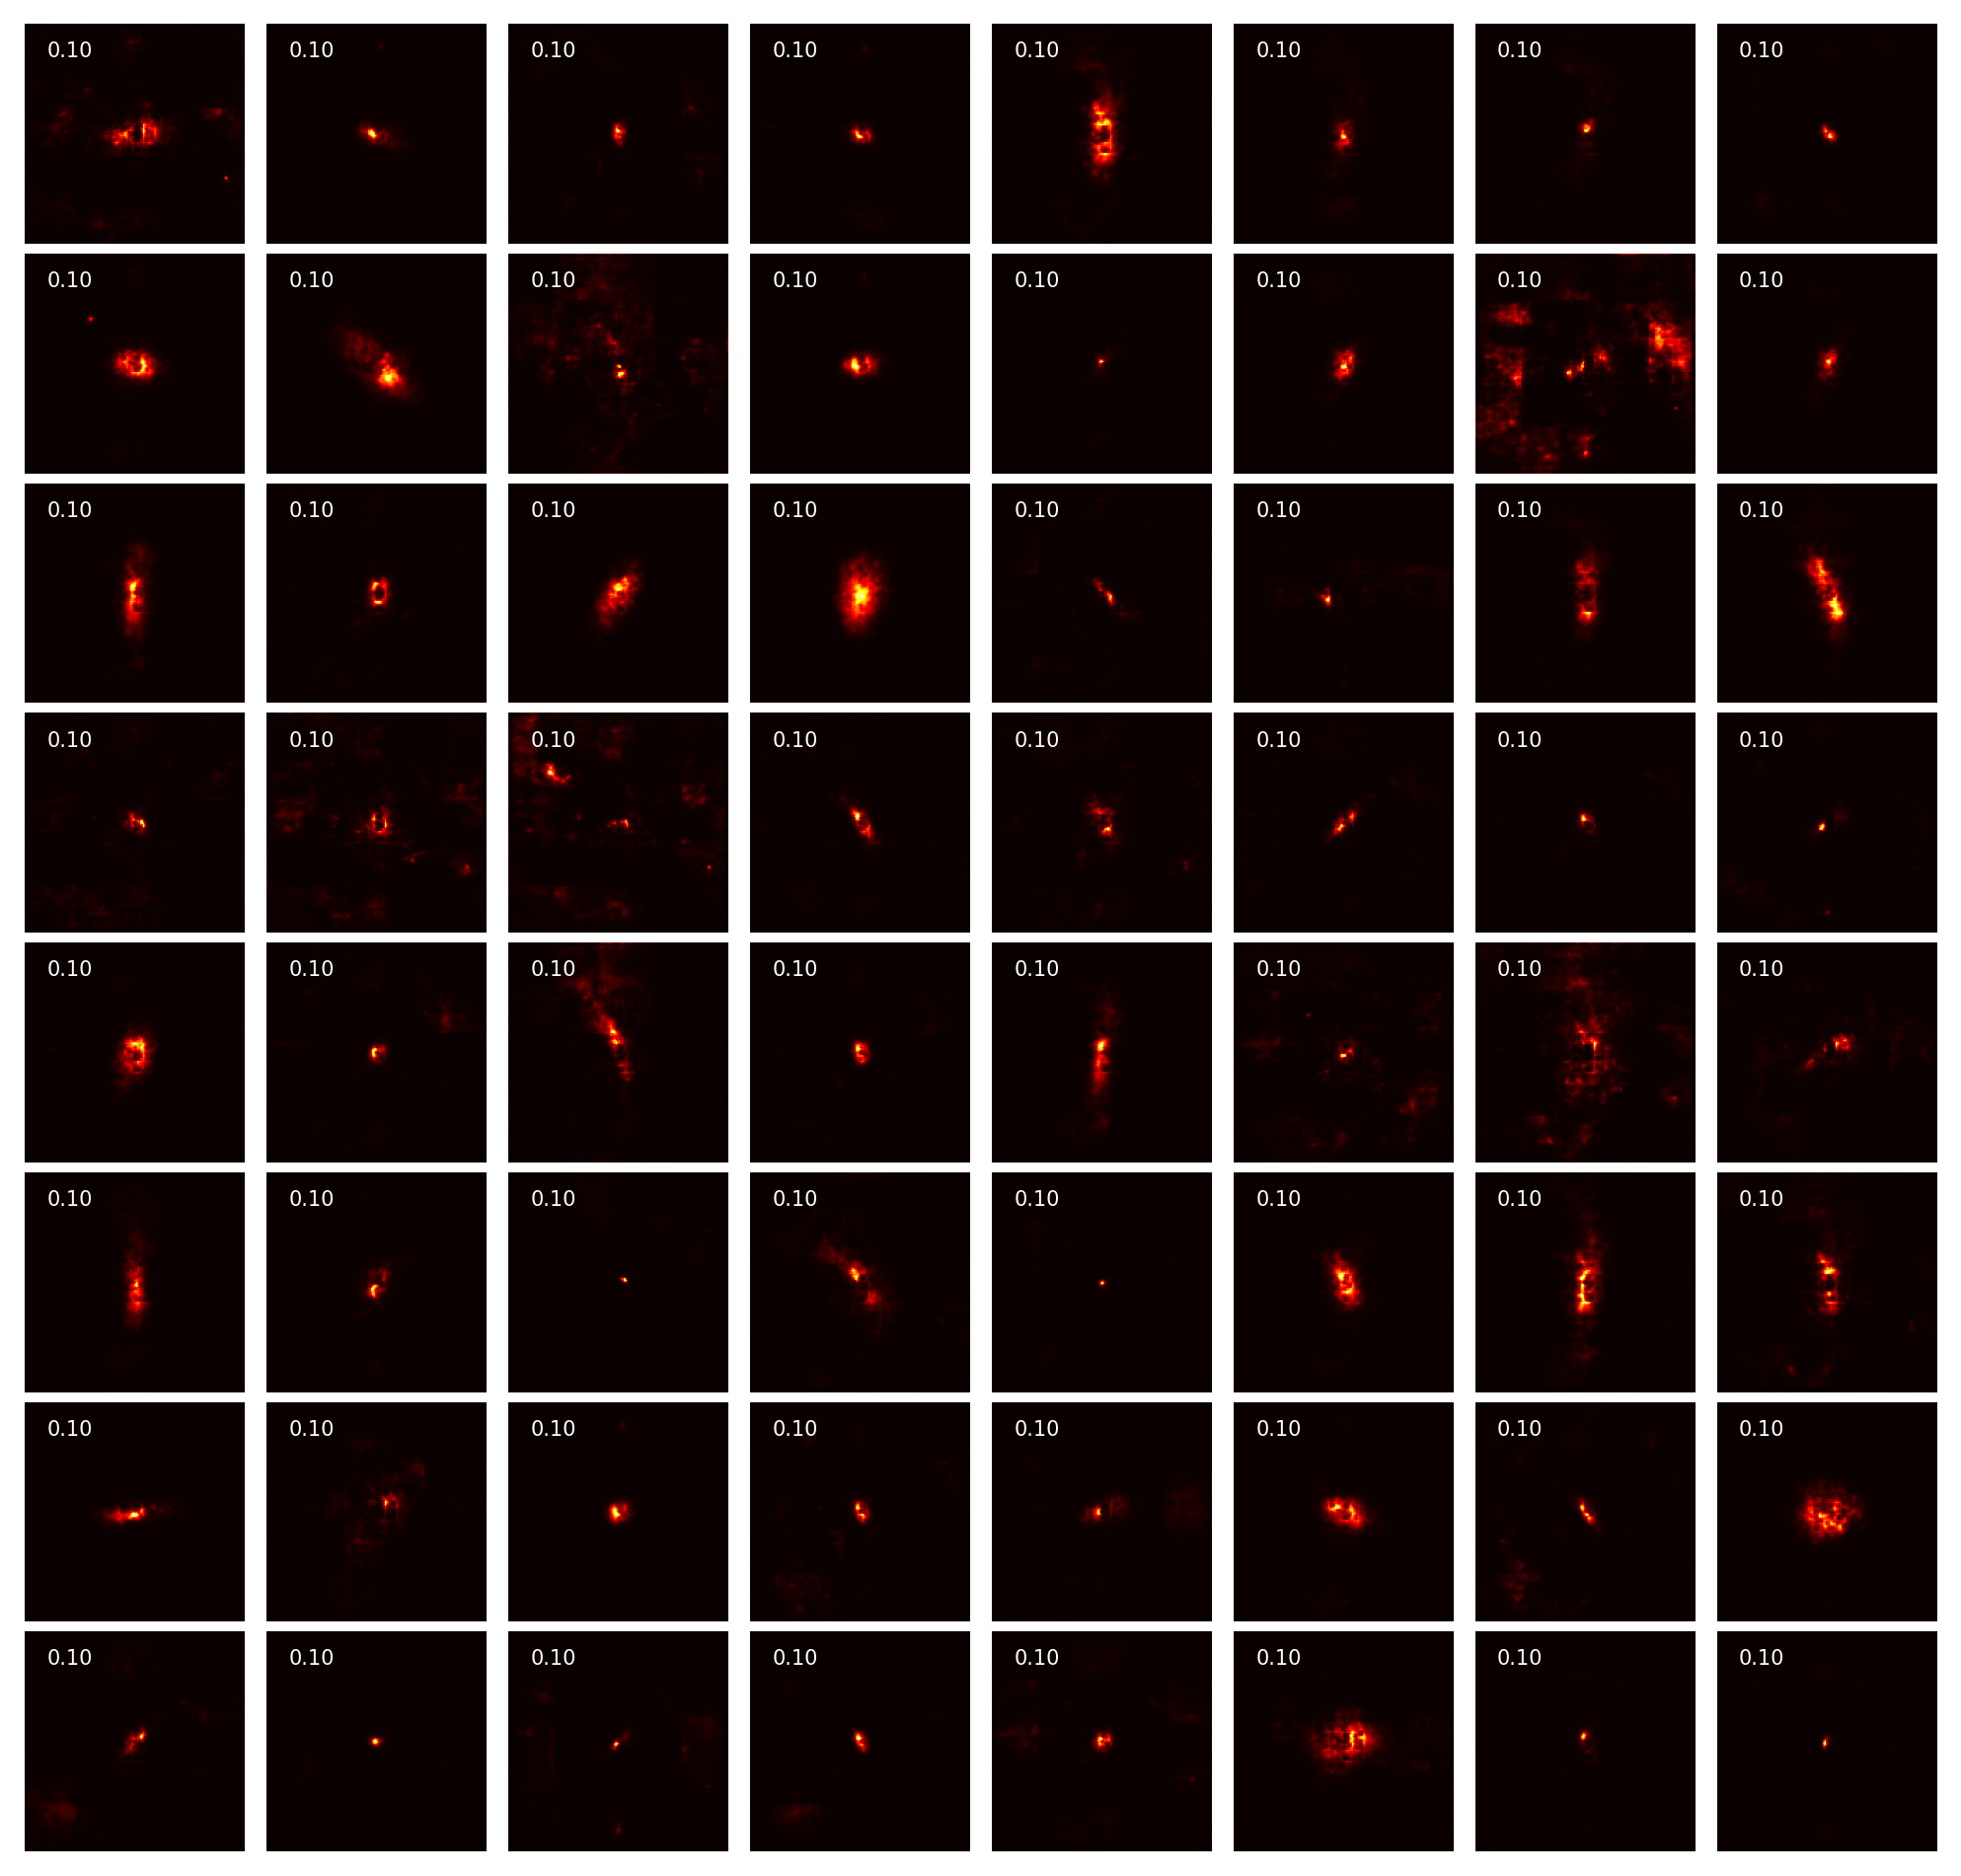

In [79]:
redshift = 0.1
generate_cvae(redshift, colour = 'hot')